In [ ]:
'''env: DL_image'''
import os
# Pretrained Inception V3:
## settings
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

suf = "1205_074135"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/test_dir"
trans_test = 311
transform = transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                  ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Load the model
from torchvision import models
import torch.nn as nn
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, n_classes)

md_name = "best_test_HAM10000_"+ suf+ ".pth"
state_dict = torch.load(os.path.join(data_root, suf, md_name), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval() 

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

In [ ]:
'''env: DL_image'''
## load the small validation set (did not use for training models) for conformal prediction
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/val_dir_cp"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs_val.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels_val.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

In [2]:
'''env: sklearn'''
## Load the .npy file
import numpy as np
import os
suf = "1205_074135"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))
smx_val = np.load(os.path.join(data_root, suf, "cp_softmax_outputs_val.npy"))
labels_val = np.load(os.path.join(data_root, suf, "cp_labels_val.npy"))

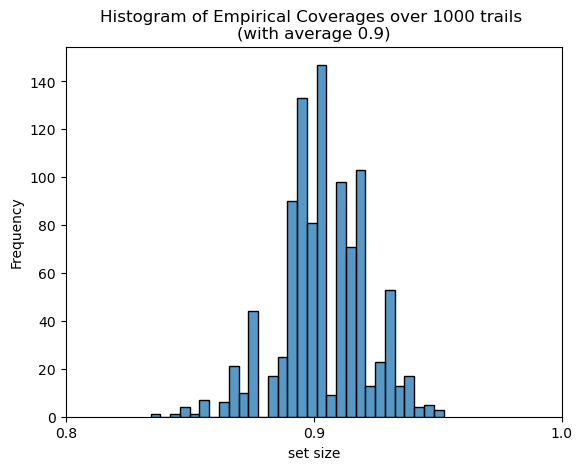

In [3]:
from CP import CP
nm = "InceptionV3"
## APS
### correctness check
cp = CP(nm, smx=smx, labels=labels, n_cali=1112, R=1000)
scores = cp.get_APS_score(smx, labels)
cp.cc(scores)

The empirical coverage is: 0.907035175879397


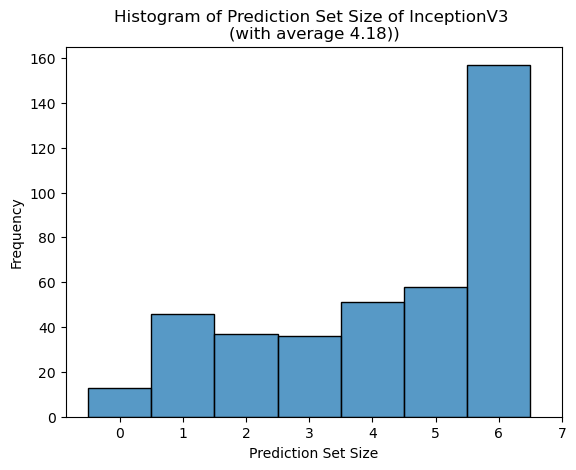

The feature-stratified coverage array is:
 [0.90909091 0.9        0.81818182 0.93333333 0.925      0.93273543
 0.84615385]
The size-stratified coverage array is:
 [0.84782609 0.89189189 0.95695364]


In [4]:
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [5]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP(nm, smx=smx, labels=labels, n_cali=1112)
    ps = cp.get_APS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.8743718592964824, 0.9020100502512562, 0.9195979899497487, 0.8894472361809045, 0.8944723618090452, 0.8994974874371859, 0.914572864321608, 0.9095477386934674, 0.9020100502512562, 0.8969849246231156, 0.9045226130653267, 0.8919597989949749, 0.8869346733668342, 0.914572864321608, 0.914572864321608, 0.8969849246231156, 0.8944723618090452, 0.8919597989949749, 0.9095477386934674, 0.8919597989949749]
the average size of prediction sets for each data split is:
 [3.95, 4.0, 4.19, 4.07, 4.05, 4.07, 4.2, 4.01, 4.14, 4.17, 3.91, 4.13, 4.1, 4.12, 4.07, 3.98, 4.13, 4.04, 4.04, 4.13]
the fsc metric for each data split is:
 [0.7777777777777778, 0.7777777777777778, 0.7692307692307693, 0.8, 0.6428571428571429, 0.7272727272727273, 0.8333333333333334, 0.8, 0.6666666666666666, 0.7333333333333333, 0.825, 0.625, 0.8125, 0.7272727272727273, 0.7142857142857143, 0.8, 0.8, 0.7, 0.8, 0.6363636363636364]
the ssc metric for each data split is:
 [0.7272727272727273, 0

The empirical coverage is: 0.9020618556701031


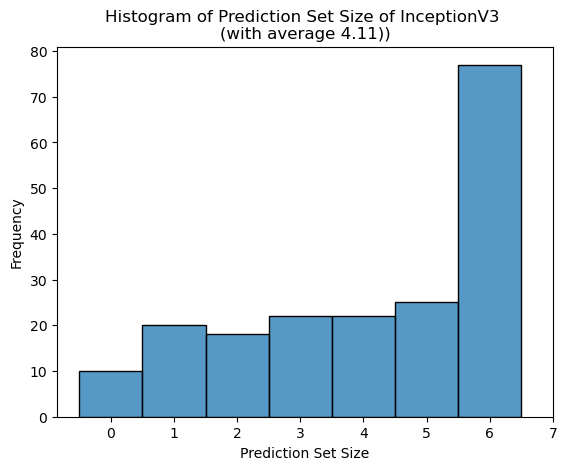

The feature-stratified coverage array is:
 [0.875      0.8        0.81818182 1.         1.         0.92361111
 1.        ]
The size-stratified coverage array is:
 [0.9        0.94444444 0.95890411]


In [6]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val)
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [7]:
## RAPS
### CV for hyper parameters lam_reg and k_reg
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112)
cp.cv_hypas()

Optimal parameters: lam_reg=0.0005, k_reg=3
Coverage: 0.9046895109395109, Average set size: 2.429890604890605


In [8]:
lam_reg=1e-6
k_reg=2

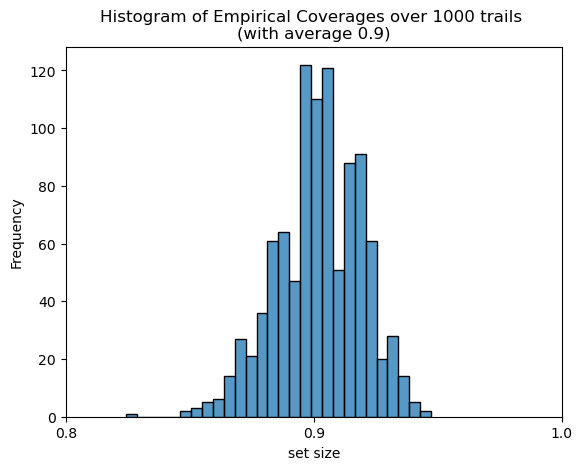

In [9]:
## correctness check
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, R=1000, lam_reg=lam_reg, k_reg=k_reg)
scores = cp.get_RAPS_score(heu_score=smx, lbs=labels)
cp.cc(scores)

The empirical coverage is: 0.8969849246231156


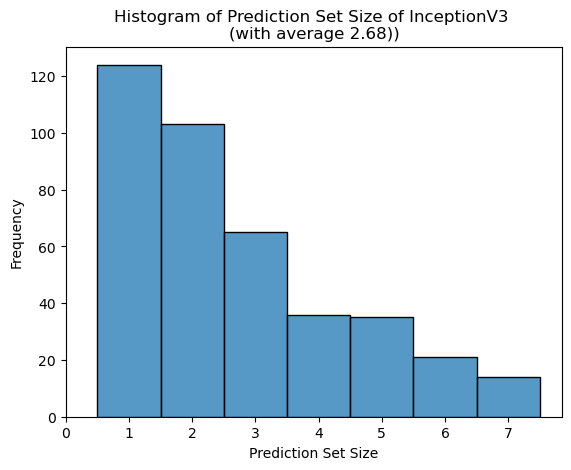

The feature-stratified coverage array is:
 [0.44444444 0.88888889 0.68       0.82352941 0.78378378 0.99196787
 0.55555556]
The size-stratified coverage array is:
 [0.90322581 0.86407767 0.9122807 ]


In [10]:
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [24]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
N = 1000
for i in range(N):
    cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, k_reg=k_reg, lam_reg=lam_reg)
    ps = cp.get_RAPS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))

np.save(f"{data_root}/{suf}/emp_cover_raps.npy", ec_list)
np.save(f"{data_root}/{suf}/sps_raps.npy", sps_avg_list)
np.save(f"{data_root}/{suf}/fsc_raps.npy", fsc_list)
np.save(f"{data_root}/{suf}/ssc_raps.npy", ssc_list)

In [ ]:
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

The empirical coverage is: 0.9175257731958762


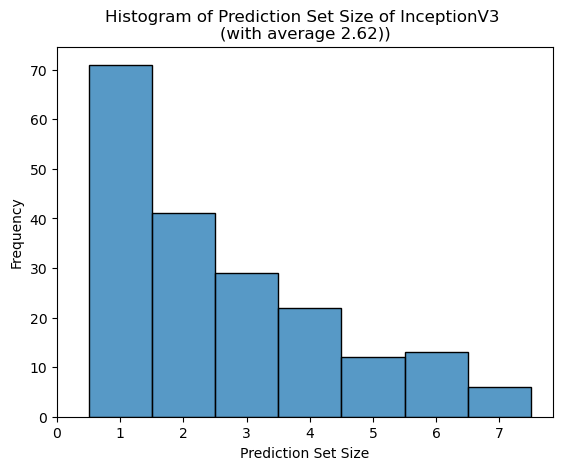

The feature-stratified coverage array is:
 [0.5        0.86666667 0.77272727 1.         1.         0.97222222
 0.66666667]
The size-stratified coverage array is:
 [0.90140845 0.95121951 0.91463415]


In [12]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, sc=1, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val, k_reg=k_reg, lam_reg=lam_reg)
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()